In this lab we will tackle two tasks: 
  - image classification: what is the object in the center of a picture?
  - localisation: where is the object in a larger picture?

Firstly we will train a small convolutional network to classify digits on MNIST dataset. 
Then we will use this network as a starting point for a new model used to localise a digit in an image containing noise. This is an artificial task but it is a good example to investigate aspects of transfer learning. 

In other, more challenging tasks we can follow a similar aproach:
  - get a model trained on a simpler tasks, or a tasks where we have more data
  - use a part of the pretrained model and incorporate it into a model designed for current task
  - freeze the pretrained part or finetune it

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot
# we need google drive access to upload the datasets
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
# Training settings    
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 3
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In order to familiarize ourselfs with the operations used in convolutional networks, lets take some random data and apply some common operations upon them. 

In [36]:
x = torch.tensor([[5,4,3,2,1],[8,5,7,1,2]])
print(x)
print(f'tensor x has shape: {x.shape}')

m1, ind1 = torch.max(x, dim=0)
m2, ind2 = torch.max(x, dim=1)

print(f'max over first dimmension: {m1}')
print(f'max over second dimmension: {m2}')

tensor([[5, 4, 3, 2, 1],
        [8, 5, 7, 1, 2]])
tensor x has shape: torch.Size([2, 5])
max over first dimmension: tensor([8, 5, 7, 2, 2])
max over second dimmension: tensor([5, 8])


We start with samples having dim_in = 1000 features. We create a tensor, usualy called a batch, having dimensions $batch\_size \times dim_{in} = 64 \times 1000$ with $batch\_size$ samples, each having size $dim\_{in}$. All the operations of a neural network will be applied independently on each sample of the bach.

In [37]:
# torch.rand creates a tensor containing numbers distributed uniformly in [0,1]
data = torch.rand(args.batch_size, 1000)

# nn.linear creates a fully-connected layer (linear layer) implementing the 
# function y = W x + b for every vector x in the input
# it is defined by the parameters: weights W of size [100,1000] and bias b of size 100
# it lineary projects the input x of size 1000 into the output y of size 100

# create the fully connected operation:
linear_op = nn.Linear(in_features = 1000, out_features = 100)

# linear is applied independently on every element in data
# input data has shape batch_size x 1000 - a number of batch_size vectors of size 1000. 
# From every such vector the linear operation results in anather vector of size dim_out = 100

# apply the fully connected operation on your data
out = linear_op(data)

print(f'input has shape: {data.shape}')
print(f'output has shape: {out.shape}')


input has shape: torch.Size([64, 1000])
output has shape: torch.Size([64, 100])


Now lets define a tensor with more dimensions: $batch\_{size} \times H \times W \times dim\_{in}$. This can be seen as a $H \times W$ map where each point in the map has $dim\_{in}$ features or can be seen as $H * W$ independent vectors of size $dim\_{in}$. Now lets apply the same linear, fully-connected function as above, independently on each of these $H * W$ vectors.


In [38]:
data2 = torch.rand(args.batch_size, 28, 28, 1000)

# We use the same function defined above. It will take as input any tensors with a
# fix last dimension (e.g 23x24x1000 or 45x1x1x2x3x1000 as long as the last
# dimension is 1000) and independently apply the operations on every point of the map

out2 = linear_op(data2)

print(f'input has shape: {data2.shape}')
print(f'output has shape: {out2.shape}')



input has shape: torch.Size([64, 28, 28, 1000])
output has shape: torch.Size([64, 28, 28, 100])


We  call the $H$ and $W$ dimensions, the spatial dimensions and see the tensor as a 2D map, each point having a number of $dim$ features. We can apply convolutional layers on this type of input.

In [39]:
# data2 has shape [batch_size x H x W x dim_in]
# In order to use convolutional operations as defined in pytorch we must place the 
# channels dimension of the tensor on the second axis. So we transpose 
# this tensor into another tensor with shape [batch_size x dim_in x H x W]
# such that the H x W vectors remain the same, but are arranged in memory in a different order.


# !! Attention !! do NOT simply reshape the tensor by doing data2.view(batch_size, dim_in, H, W)! 
# As sugested by the name, this would just see the same data in different ways, but the underling 
# data would remain unchange.

# eg. the following matrix has dimension 2 x 3, with 2 vectors if size 3: (1,2,3) and (4,5,6)
# A = 
# | 1 2 3 |
# | 4 5 6 |
# by transposing, we want the same vectors but arraged differently as a 3 x 2 matrix
# A.permute(1,0)
# | 1 4 |
# | 2 5 |
# | 3 6 |
# by using A.view(3,2) we would obtain
# | 1 2 |
# | 3 4 |
# | 5 6 |

A = torch.tensor([[1,2,3],[4,5,6]])
print(f'A: {A}')
# view() and reshape() are very similar as effect. Both of them rearrange the elements of the tensor 
# For view, the data is not altered in memory, while the reshape try to do the view if the data 
# is stored in a contiguous place, but copy the data into a contiguous tensor if it's not already the case
print(f'view A: {A.view(3,2)}')
print(f'reshape A: {A.reshape(3,2)}')
# transpose permute 2 axis of the tensor, while permute is used to permute all the axis 
# according to a given permutatinon
print(f'transpose A: {A.transpose(1,0)}')
print(f'permute A: {A.permute(1,0)}')

input_map = data2.permute(0,3,1,2) # the previous forth dimmension is now the second
print(f'data2 has shape: {data2.shape}')
print(f'input_map has shape: {input_map.shape}')

# we create a convolutional operation with filters (kernels) of sizes 5 x 5 x in_channels
# and we use a number of out_channels such kernels
conv1  = nn.Conv2d(in_channels=1000, out_channels=100, kernel_size=5, padding=0)

# apply the concolution operation on the input map
map1 = conv1(input_map)
# observe the size of the resulting map 
print(f'map1 has shape: {map1.shape}')



A: tensor([[1, 2, 3],
        [4, 5, 6]])
view A: tensor([[1, 2],
        [3, 4],
        [5, 6]])
reshape A: tensor([[1, 2],
        [3, 4],
        [5, 6]])
transpose A: tensor([[1, 4],
        [2, 5],
        [3, 6]])
permute A: tensor([[1, 4],
        [2, 5],
        [3, 6]])
data2 has shape: torch.Size([64, 28, 28, 1000])
input_map has shape: torch.Size([64, 1000, 28, 28])
map1 has shape: torch.Size([64, 100, 24, 24])


In [40]:
# lets apply a new convolution layer multiple times, each one reusing
# the same function, with the same parameters

conv2  = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, padding=0)

map2 = conv2(map1)
map3 = conv2(map2)
map4 = conv2(map3)

print(f'map2 has shape: {map2.shape}')
print(f'map3 has shape: {map3.shape}')
print(f'map4 has shape: {map4.shape}')

# the 5x5 kernel reduces the size of each of the spatial dimension by 4
# why?

# we can eliminate the reduction in spatial size resulted by the convolution by using padding
conv3  = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, padding=2)

map5 = conv3(map4)
print(f'map5 has shape: {map5.shape}')

map2 has shape: torch.Size([64, 100, 20, 20])
map3 has shape: torch.Size([64, 100, 16, 16])
map4 has shape: torch.Size([64, 100, 12, 12])
map5 has shape: torch.Size([64, 100, 12, 12])


Although we have applied a succesion of convolutional layers, this is not a really useful convolutional neural network


1.   we have used convolutional operations in succesion, without non-linearity in between. As with fully-connected layers, composition of linear operation is a linear operation, so this is equivalent with a single convolution (but with a larger kernel). We need a non-linearity like ReLU in between the convolutional layers


2.   we have used the SAME convolutional operation multiple times. While this could be useful in some cases (spoiler: recurrent convolutional networds), this is not the most used case. Generally, we use different operations (having different parameters) at each layer.


Also, it is usual to use max-pooling operations, in convolutional networks. This reduces the spatial resolution of the data and gives the network invariance to small translations between the parts.





In [41]:
conv1  = nn.Conv2d(in_channels=1000, out_channels=100, kernel_size=5, padding=0)
conv2  = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, padding=0)
conv3  = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, padding=0)

map1 = F.relu(conv1(input_map))
map2 = F.max_pool2d(map1, 2, 2)
map3 = F.relu(conv2(map2))
map3 = F.max_pool2d(map3, 2, 2)

print(f'map3 shape: {map3.shape}')


map3 shape: torch.Size([64, 100, 4, 4])


For classification problems, when we have K classes, we want to predict a vector of size K,  where dimension k represents the probability of class k.

Thus, for every sample in the batch, we want one K dimensional vector. Lets take our map3 tensor of size $batch\_{size} 
\times 4 \times 4 \times 100$ as example. 

We can predict a vector representing the probability of each classes in two ways:
1. linearise every sample of size $4 \times 4 \times 100$ as a vector of size $4 * 4 * 100 = 1600$ elements and use a fully connected layer to predict the desired output

2. process every sample  $4 \times 4 \times 100$ with a convolution large enough such that it takes into consideration the whole input. Thus we must use convolutions with filters $4 \times 4$. Having the filters dimension the same as the spatial dimensions of the input results in a single output for both spatial dimensions, thus the output is a map of size $1 \times 1$.


QUESTION: how does the two aproaches differ?

3. apply a $4 \times 4$ mean-pooling on the spatial dimension to aggregate the information from the entire map into a single vector, then predict the desired output from it. This is lighter in terms of parameters, but it loses teh spatial information.

In [42]:
fully = nn.Linear(in_features = 4*4*100, out_features = 10)
conv = nn.Conv2d(in_channels=100, out_channels=10, kernel_size=4, padding=0)

map3_linearised = map3.view(args.batch_size,-1)
print(f'map3_linearised shape: {map3_linearised.shape}')

out1 = fully(map3_linearised)
out2 = conv(map3)

print(f'out1 shape: {out1.shape}')
print(f'out2 shape: {out2.shape}')




map3_linearised shape: torch.Size([64, 1600])
out1 shape: torch.Size([64, 10])
out2 shape: torch.Size([64, 10, 1, 1])





# > MNIST classification


---
We will train a convolutional network to classify digits. The architecture should be similar to:
  - conv layer: 20 filters, kernel size: 5x5, stride:1
  - relu
  - max pool: kernel size: 2x2, stride:2
  - conv layer: 50 filters, kernel size: 5x5, stride:1
  - relu
  - max pool: kernel size: 2x2, stride:2
  - fully connected: 500 neurons
  - relu
  - fully connected: 10 neurons
  - log softmax
   
  

In [43]:
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500
class CNN(nn.Module):
    # the init() is called a single time, when you create the model
    # so all the layers should be created here.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fc1 = nn.Linear(in_features = 4 * 4 * no_filter2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = 10)
    # the forward() is called at each iteration, so we only apply the already
    # created operations inside this function 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.75)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Load MNIST dataset containing drawn digits with a total of 50k training samples and 10k testing samples. Each image has one channel and 28x28 pixels.


In [44]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-01 19:21:06--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-01 19:21:07--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.3’

MNIST.tar.gz.3          [             <=>    ]  33.20M  11.9MB/s    in 2.8s    

2021-04-01 19:21:10 (11.9 MB/s) - ‘MNIST.tar.gz.3’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

Labels of the shown images: tensor([0, 7, 1, 0, 0])


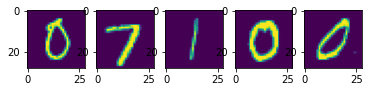

In [45]:
# we create a loader to iterate through the dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_loader))
# set_trace()

f, axarr = pyplot.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0])
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')


Train Convolutional network for MNIST classification.

In [46]:
# define two functions, one for training the model and one for testing it

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += F.nll_loss(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

Create an optimizer and call the training / testing functions.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308650
Train Epoch: 1 [9984/60000 (17%)]	Loss: 0.412927
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.166981
Train Epoch: 1 [29952/60000 (50%)]	Loss: 0.160213
Train Epoch: 1 [39936/60000 (67%)]	Loss: 0.158168
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.245158
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.135008

Test set: Average loss: 0.1195, Accuracy: (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.095173
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.131568
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.036893
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.179712
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.109405
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.098016
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.189529

Test set: Average loss: 0.0791, Accuracy: (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.095048
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.084725
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.052539
Train Epoch: 3 [29952/60000 (50%)]	Loss: 0.043594
Train Epoch: 3 [

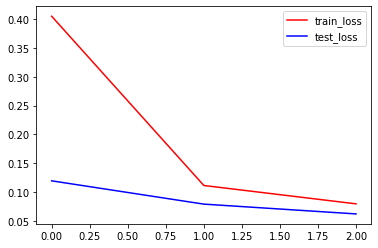

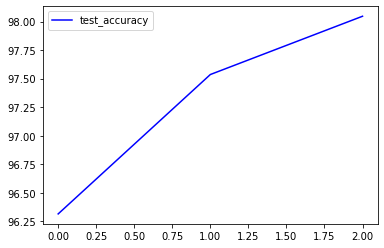

In [47]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

# move the model to the GPU (when available)
model = CNN().to(device)
# create an Stochastic Gradient Descent optimiser
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs + 1):
# for epoch in range(1, 3):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(args, model, device, test_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

#plot the loss/accuracy    
pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

# save the final model
torch.save(model.state_dict(),"mnist_cnn.pt")


